# Import Library

In [1]:
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
import shutil
import itertools
import pathlib

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam, Adamax

In [4]:
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Get data

In [ ]:
# Only use training data from origin dataset for both training and testing 
!unzip /kaggle/input/dogs-vs-cats/train.zip

In [7]:
path, dirs, files = next(os.walk('/kaggle/working/train'))
file_count = len(files)
print('path:', path)
print('num_of_dir:', len(dirs))
print('num_of_file:', file_count)

path: /kaggle/working/train
num_of_dir: 0
num_of_file: 25000


In [8]:
# Store small version dataset
# shutil.rmtree(base_dir)
base_dir = '/kaggle/working/dogs_vs_cats_small_dataset'
os.mkdir(base_dir)

# Create Directories for Train, Val and Test

In [9]:
# Create dataset dir script
def create_dataset_dir(parent, dir):
    dir = os.path.join(parent, dir)
    os.mkdir(dir)

In [10]:
# Create train, val, test dir
for dir_name in ['train', 'valid', 'test']:
    create_dataset_dir(base_dir, dir_name)

In [11]:
# Create dogs, cats dir inside train, val, test dir
for dir_name in ['train', 'valid', 'test']:
    for class_name in ['cats', 'dogs']:
        create_dataset_dir(base_dir, dir_name + '/' + class_name)

In [12]:
# Set dir name
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(base_dir, 'train/cats')
valid_cats_dir = os.path.join(base_dir, 'valid/cats') 
test_cats_dir = os.path.join(base_dir, 'test/cats')
train_dogs_dir = os.path.join(base_dir, 'train/dogs')
valid_dogs_dir = os.path.join(base_dir, 'valid/dogs') 
test_dogs_dir = os.path.join(base_dir, 'test/dogs')  

# Move data to structured dir

In [13]:
# Class counting
dir_path = '/kaggle/working/train'

cat_count = 0
dog_count= 0
for i in os.listdir(dir_path):
    if i.startswith('cat.'):
        cat_count += 1
    elif i.startswith('dog.'):
        dog_count += 1
        
print(f"Number of cat images: {cat_count}")
print(f"Number of dog images: {dog_count}")

Number of cat images: 12500
Number of dog images: 12500


In [14]:
original_dataset_dir = '/kaggle/working/train'

# Move data script
def move_data_to_dir(class_name, dir, start_idx, end_idx):
    fnames = ['{}.{}.jpg'.format(class_name, i) for i in range(start_idx, end_idx)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(dir, fname)
        shutil.copyfile(src, dst)

In [15]:
# 80% train : 10% valid : 10% test

# Move cats
move_data_to_dir('cat', train_cats_dir, 0, 10000)
move_data_to_dir('cat', valid_cats_dir, 10000, 11250)
move_data_to_dir('cat', test_cats_dir, 11250, 12500)

# Move dogs
move_data_to_dir('dog', train_dogs_dir, 0, 10000)
move_data_to_dir('dog', valid_dogs_dir, 10000, 11250)
move_data_to_dir('dog', test_dogs_dir, 11250, 12500)

In [16]:
# Check number
print(f'Total training cat images: {len(os.listdir(train_cats_dir))}')
print(f'Total validation cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Total test cat images: {len(os.listdir(test_cats_dir))}')
print('\n')
print(f'Total training dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Total validation cat images: {len(os.listdir(valid_dogs_dir))}')
print(f'Total test cat images: {len(os.listdir(test_dogs_dir))}')

Total training cat images: 10000
Total validation cat images: 1250
Total test cat images: 1250


Total training dog images: 10000
Total validation cat images: 1250
Total test cat images: 1250


# Image Data Generator

In [17]:
img_size = (224, 224)
img_shape = (img_size[0], img_size[1], 3)
batch_size = 32

In [18]:
train_gen = ImageDataGenerator().flow_from_directory(
    train_dir, target_size = img_size ,class_mode = 'binary',
    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

valid_gen = ImageDataGenerator().flow_from_directory(
    valid_dir, target_size = img_size, class_mode = 'binary',
    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

test_gen = ImageDataGenerator().flow_from_directory(
    test_dir, target_size = img_size, class_mode = 'binary',
    color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Show Sample From Train Data

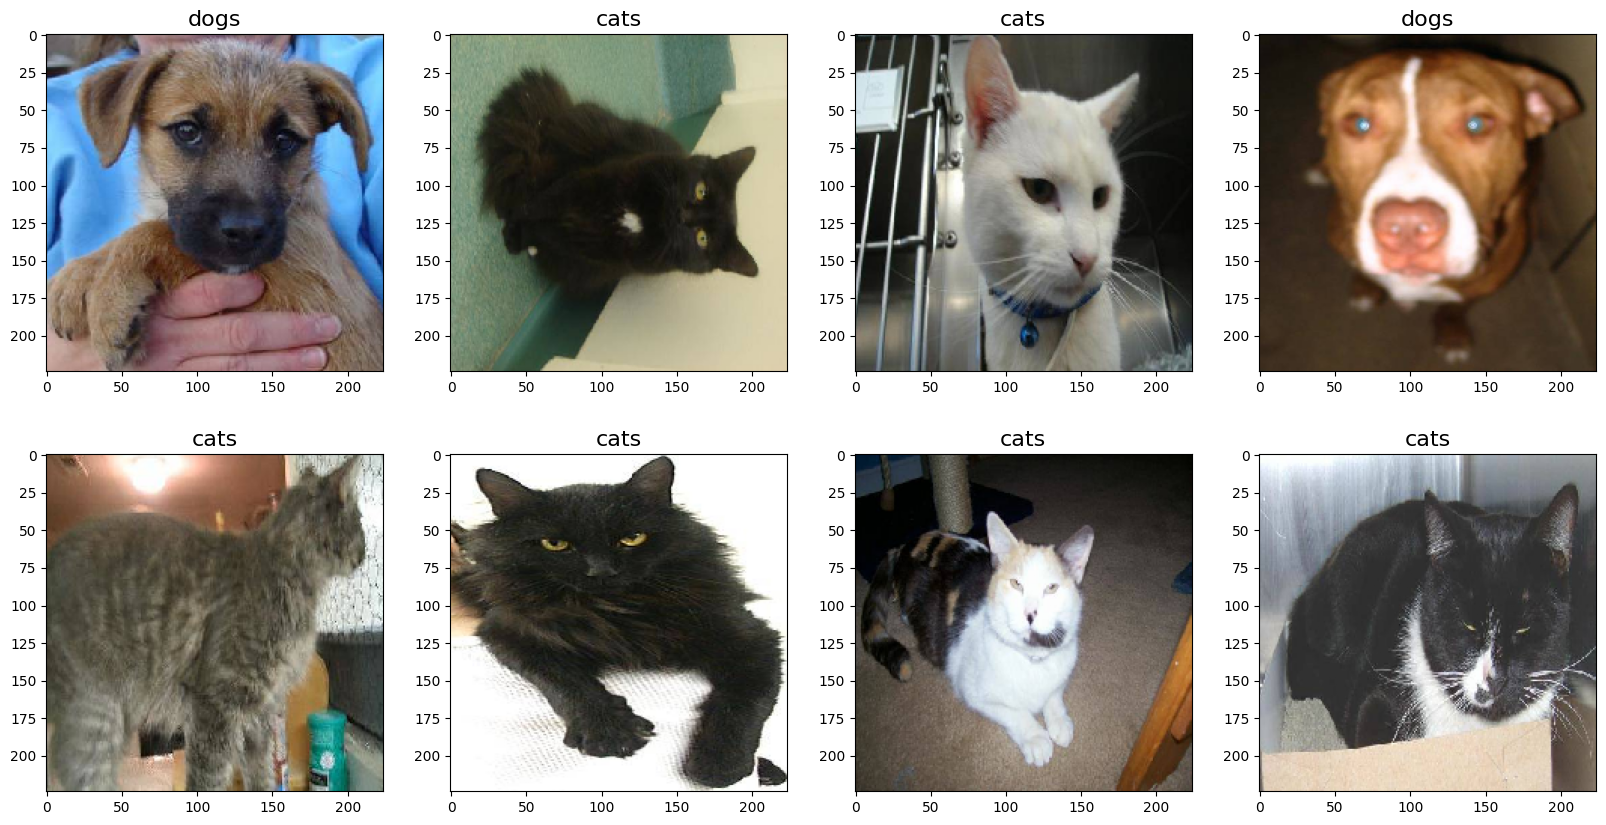

In [19]:
# Get class
g_dict = train_gen.class_indices
classes = list(g_dict.keys())

# Get a batch
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 10))

for i in range(min(8, num_samples)):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    
    # Set class name title     
    class_index = int(labels[i])
    class_name = classes[class_index]
    plt.title(class_name, fontsize=16)
    plt.grid(False)
plt.show()

# Modeling

In [20]:
# Get base_model and freeze it
base_model = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top= False, 
    weights= 'imagenet',
    input_shape= img_shape,pooling= 'max'
)
base_model.trainable= False

115263384/115263384 [==============================] - 0s 0us/step


In [21]:
# Customize model
model = Sequential([
    base_model,
    Dense(256, activation = 'relu'),
    Dropout(rate = 0.4 , seed = 40),
    Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = Adamax(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics= ['accuracy'])
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 29038328 (110.77 MB)
Trainable params: 524801 (2.00 MB)
Non-trainable params: 28513527 (108.77 MB)
_________________________________________________________________


# Training

In [22]:
history = model.fit(
    x = train_gen, 
    validation_data = valid_gen, 
    epochs = 10, 
    verbose = 1, 
    validation_steps = None, 
    shuffle = False
)

Epoch 1/10


2023-12-27 10:14:58.014152: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 174s 240ms/step - loss: 0.1044 - accuracy: 0.9728 - val_loss: 0.0496 - val_accuracy: 0.9828
Epoch 2/10
625/625 [==============================] - 145s 232ms/step - loss: 0.0448 - accuracy: 0.9847 - val_loss: 0.0538 - val_accuracy: 0.9864
Epoch 3/10
625/625 [==============================] - 145s 232ms/step - loss: 0.0408 - accuracy: 0.9858 - val_loss: 0.0561 - val_accuracy: 0.9836
Epoch 4/10
625/625 [==============================] - 145s 232ms/step - loss: 0.0337 - accuracy: 0.9891 - val_loss: 0.0508 - val_accuracy: 0.9856
Epoch 5/10
625/625 [==============================] - 145s 232ms/step - loss: 0.0285 - accuracy: 0.9901 - val_loss: 0.0434 - val_accuracy: 0.9868
Epoch 6/10
625/625 [==============================] - 145s 232ms/step - loss: 0.0296 - accuracy: 0.9893 - val_loss: 0.0448 - val_accuracy: 0.9872
Epoch 7/10
625/625 [==============================] - 145s 232ms/step - loss: 0.0252 - accuracy: 0.9921 - val_loss: 0.0472 - val_accura

# Model Performance

In [23]:
# history of acc & loss
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# min loss, max acc
index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

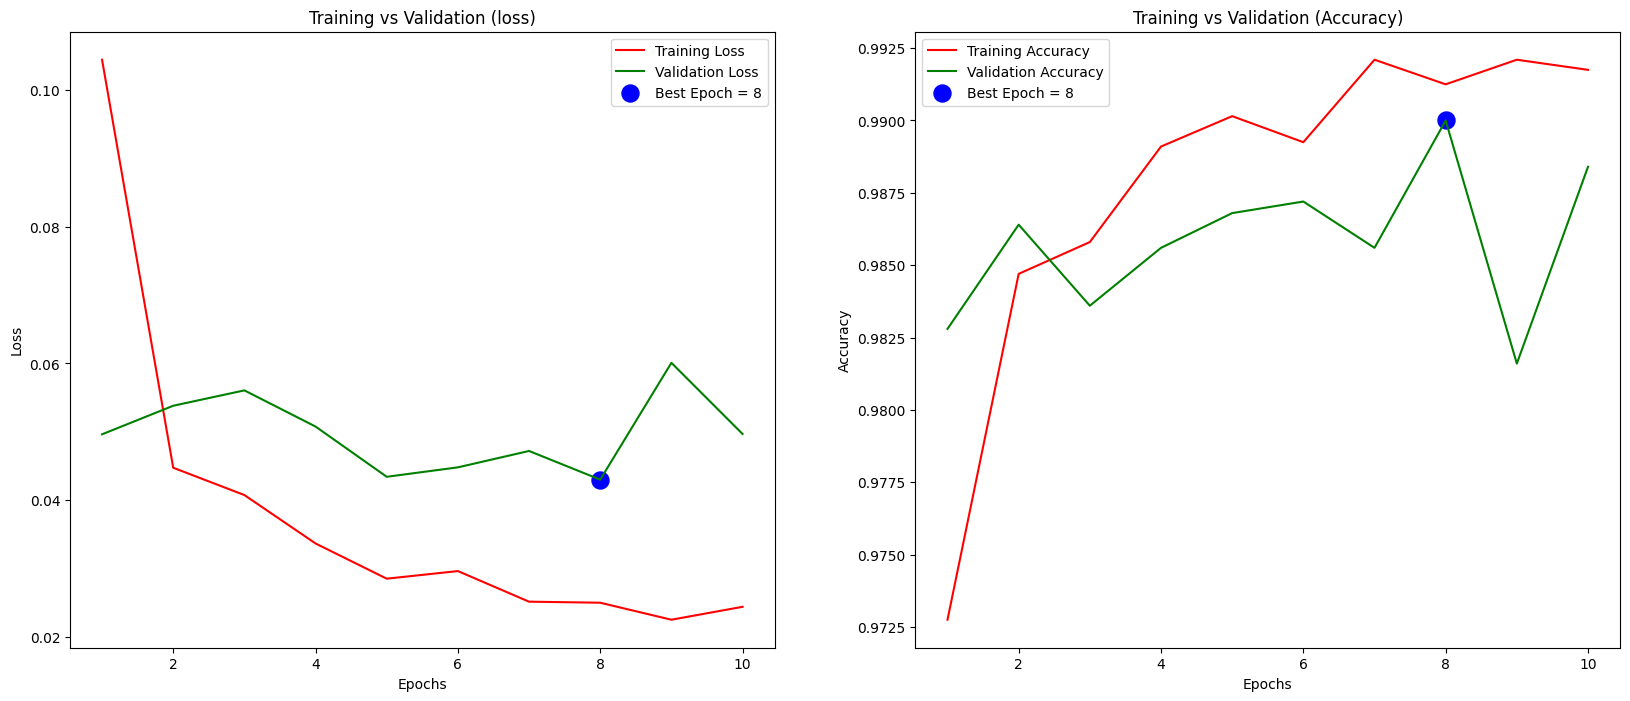

In [24]:
plt.figure(figsize= (20,8))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(Epochs, train_loss, 'r', label = 'Training Loss')
plt.plot(Epochs, val_loss, 'g', label = 'Validation Loss')
loss_label = f'Best Epoch = {str(index_loss + 1)}'
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(Epochs, train_acc, 'r', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label = 'Validation Accuracy')
acc_label = f'Best Epoch = {str(index_acc + 1)}'
plt.scatter(index_acc + 1, val_highest, s = 150 , c = 'blue', label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show();

# Model evaluation

In [25]:
val_score = model.evaluate(valid_gen, verbose = 1)
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print("\n") 
test_score = model.evaluate(test_gen, verbose = 1)
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

79/79 [==============================] - 16s 199ms/step - loss: 0.0497 - accuracy: 0.9884
Validation loss = 0.0496932677924633
Validation Accuracy = 0.9883999824523926


79/79 [==============================] - 16s 198ms/step - loss: 0.0341 - accuracy: 0.9908
Test loss = 0.034090556204319
Test Accuracy = 0.9908000230789185


In [26]:
preds = model.predict(test_gen)

# Convert the predictions to binary classes (0 or 1)
predicted_classes = (preds > 0.5).astype(int)
predicted_classes

79/79 [==============================] - 19s 196ms/step


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [27]:
# Confusion matrix
def plot_cm(y_test, y_pred):
    plt.figure(figsize=(5, 3))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Prediction classes');
    plt.ylabel('True classes');

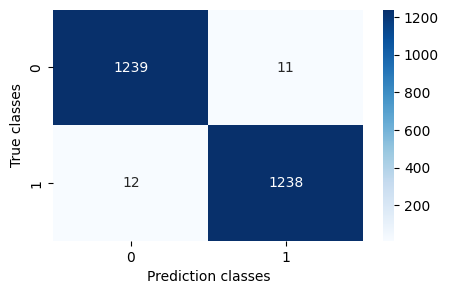

In [28]:
true_classes = test_gen.classes
plot_cm(true_classes, predicted_classes)

In [29]:
# Generate and print the classification report
classification_rep = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices)
print("\nClassification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.99      0.99      1250
        dogs       0.99      0.99      0.99      1250

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



# Mismatch Visualization

In [30]:
mismatch_indices = []
for i, (a, b) in enumerate(zip(predicted_classes, true_classes)):
    if a != b:
        mismatch_indices.append(i)
mismatch_indices = np.array(mismatch_indices)
mismatch_indices

array([  47,  149,  384,  474,  476,  485,  573,  695,  778, 1022, 1128,
       1299, 1300, 1320, 1465, 1624, 1685, 1731, 1947, 1999, 2061, 2155,
       2223])

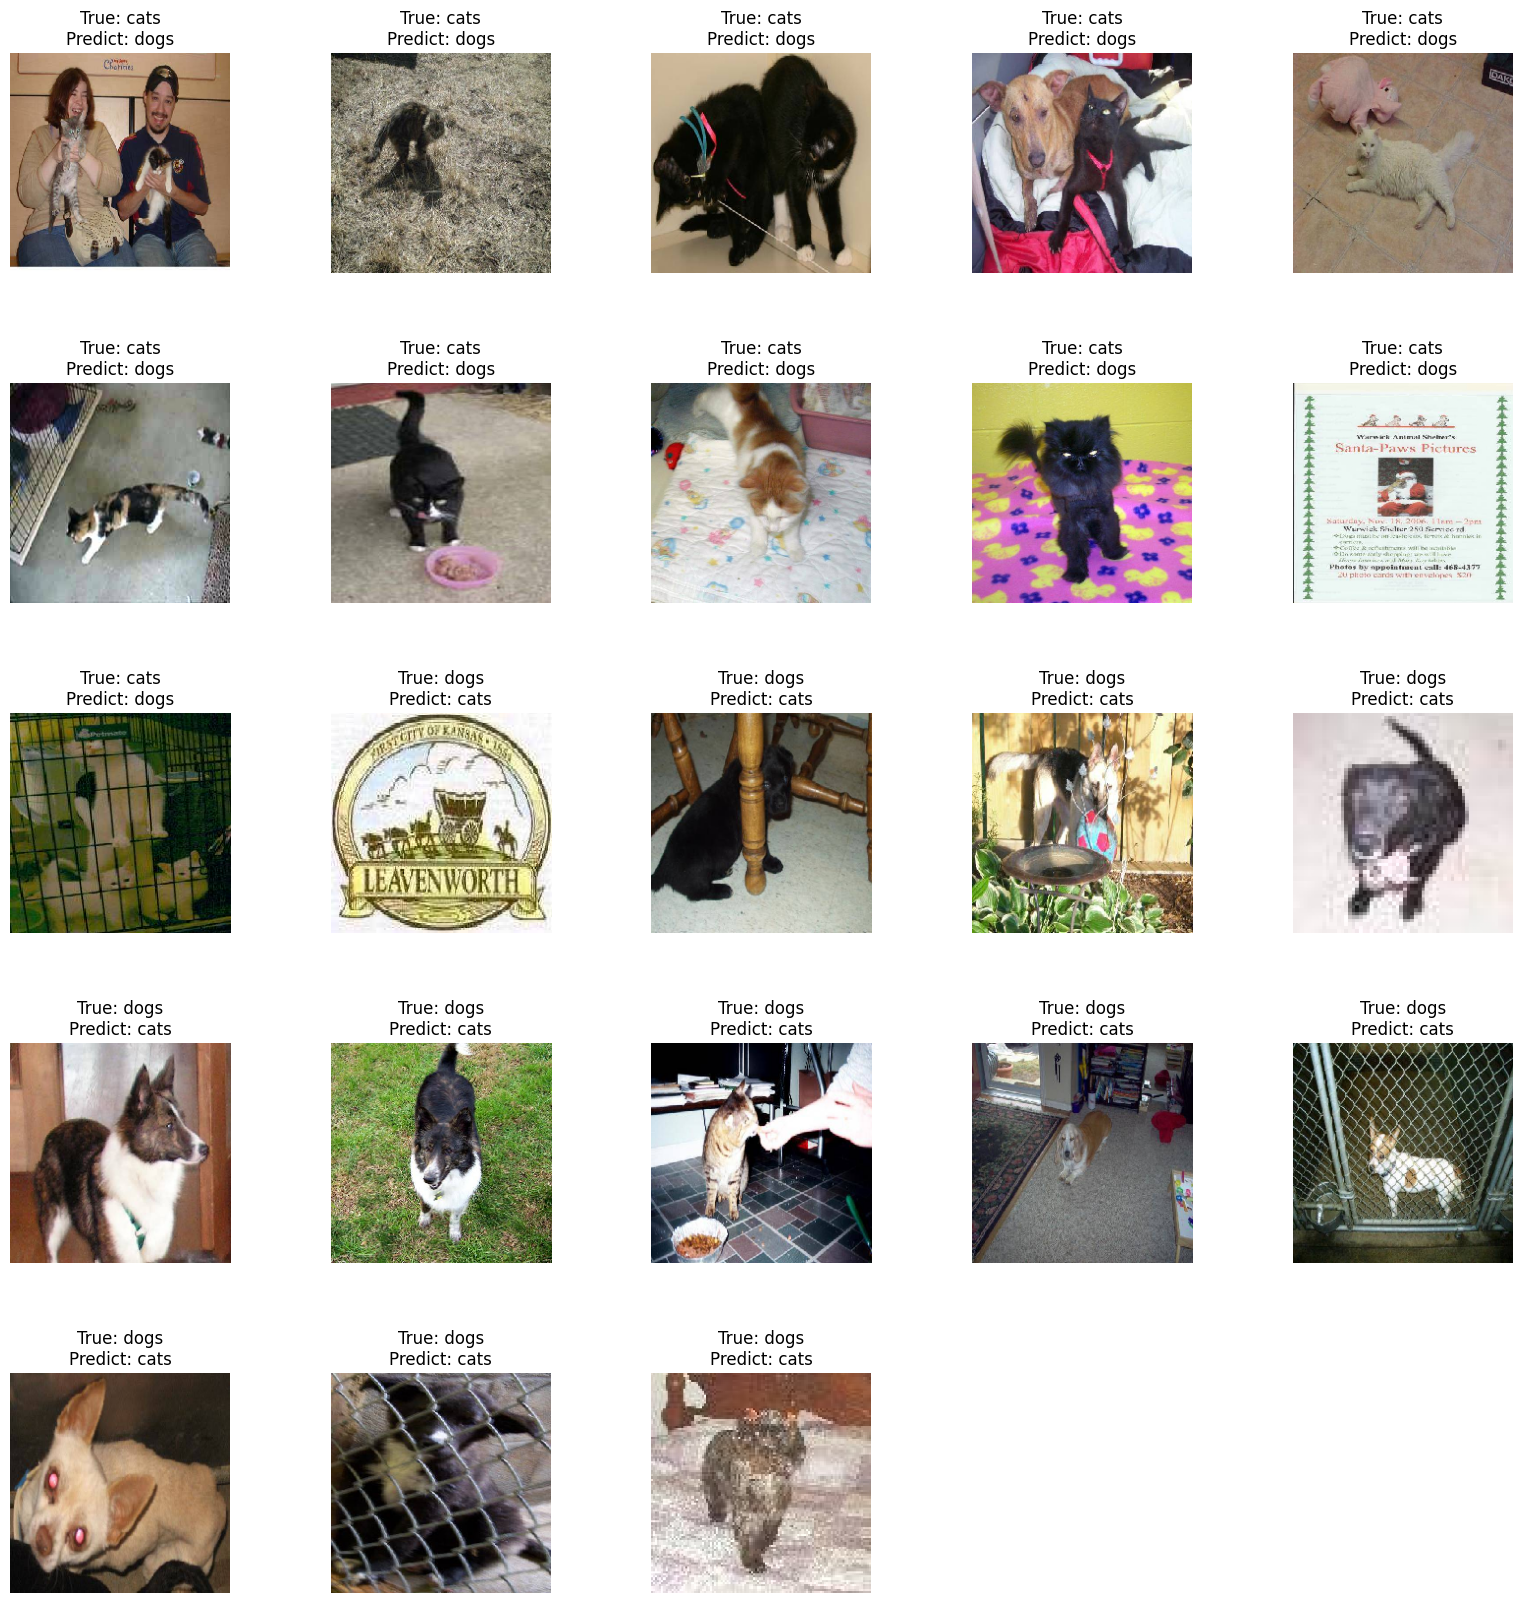

In [31]:
# Set grid size
num_columns = 5
num_rows = 5
num_images = num_columns * num_rows

plt.figure(figsize=(20, 20))

# Loop for mismatch_image
for i, index in enumerate(mismatch_indices):
    # Compute batch and image_index
    batch_index = index // batch_size
    image_index = index % batch_size
    
    images, _ = test_gen[batch_index]
    plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(images[image_index] / 255)
    plt.title(f"True: {classes[true_classes[index]]}\nPredict: {classes[predicted_classes[index][0]]}", fontsize = 12)
    plt.subplots_adjust(hspace=0.5)
    plt.axis('off')

plt.show()

# Save model

In [32]:
model.save('dogvscat.h5')

# Load model

In [33]:
model = tf.keras.models.load_model('/kaggle/working/dogvscat.h5')

# Test saved model on an image

In [34]:
def predict_an_image(img):  
    # Show image
    norm_img = img / 255
    plt.imshow(norm_img)
    plt.axis('off')
    
    # Convert to 4D image     
    img_4d = img.reshape(1, 224, 224, 3)
    
    # Predict  
    preds = model.predict(img_4d)
    predicted_classes = (preds > 0.5).astype(int)
    if predicted_classes == [[0]]:
        print('This is a cat!')
    else:
        print('This is a dog!')

## Image from batch

1/1 [==============================] - 5s 5s/step
This is a cat!


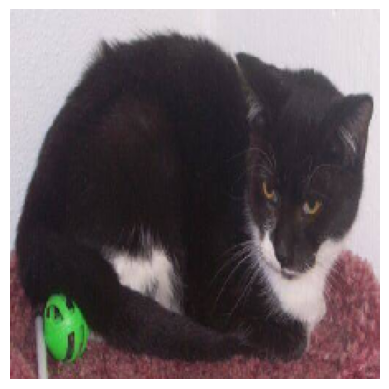

In [35]:
# Get a batch
images, labels = next(test_gen)

# Get an image from the batch
img = images[0]
predict_an_image(img)

## Your uploaded image

1/1 [==============================] - 4s 4s/step
This is a cat!


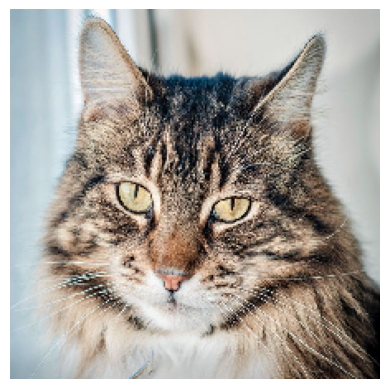

In [36]:
from tensorflow.keras.preprocessing import image

path = '/kaggle/input/mydata/cat.jpg'
img = image.load_img(path, target_size=(224, 224))
img = np.array(img)

predict_an_image(img)

# Test saved model on your testing dataset

In [37]:
# Dataset structure:
# test_dir:
# ___ dogs
# ___ cats
sample_test_gen = ImageDataGenerator().flow_from_directory(
    test_dir, target_size = img_size, class_mode = 'binary',
    color_mode = 'rgb', shuffle = False, batch_size = batch_size)
true_classes = sample_test_gen.classes

Found 2500 images belonging to 2 classes.


In [38]:
# Predict result (without labels)
preds = model.predict(sample_test_gen)
predicted_classes = (preds > 0.5).astype(int)
print(predicted_classes)

79/79 [==============================] - 19s 196ms/step
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [39]:
# Evaluate (with labels)
test_score = model.evaluate(sample_test_gen, verbose = 1)
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

79/79 [==============================] - 20s 202ms/step - loss: 0.0341 - accuracy: 0.9908
Test loss = 0.034090556204319
Test Accuracy = 0.9908000230789185


In [40]:
# Generate and print the classification report
classification_rep = classification_report(true_classes, predicted_classes, target_names=sample_test_gen.class_indices)
print("\nClassification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.99      0.99      1250
        dogs       0.99      0.99      0.99      1250

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500

